In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###### Goal of doing this analysis
- perform clustering and segmentation on the dataset and identify popular customer groups along with their definitions/rules
- perform location wise analysis to identify regional trends in India
- perform transaction related analysis to identify interesting trends that can be used by a bank to improve / optimize their user experience
- Customer Recency, Frequency, Monetory Analysis
- Network analysis or graph analysis of customer data

###### import libraries

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns

try:
    import plotly.express as px
    import plotly.graph_objects as go

except:
    !pip install plotly
    import plotly.express as px
    import plotly.graph_objects as go
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DeprecationWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

import scipy.cluster.hierarchy as sch   #to perform hierarchical clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator
#------------------------------------------------------------------
try:
    from yellowbrick.cluster import KElbowVisualizer
except:
    !pip install -U yellowbrick
    from yellowbrick.cluster import KElbowVisualizer
# Yellowbrick is a suite of visual analysis and diagnostic tools designed to facilitate machine learning with scikit-learn. The library implements a new core API object, 
# the Visualizer that is an scikit-learn estimator — an object that learns from data. 

###### Data collection

In [3]:
df = pd.read_csv("bank_transactions.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
df.shape

(1048567, 9)

###### Data cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [6]:
#details of the dataset
def check(df):
    l = []
    columns = df.columns
    for col in columns:
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        sum_null = df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check = pd.DataFrame(l)
    df_check.columns = ['column','dtypes','nunique','sum_null']
    return df_check


In [7]:
check(df)

,column,dtypes,nunique,sum_null
0,TransactionID,object,1048567,0
1,CustomerID,object,884265,0
2,CustomerDOB,object,17254,3397
3,CustGender,object,3,1100
4,CustLocation,object,9355,151
5,CustAccountBalance,float64,161328,2369
6,TransactionDate,object,55,0
7,TransactionTime,int64,81918,0
8,TransactionAmount (INR),float64,93024,0


#drop missing data

In [8]:
df.dropna(inplace=True)
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


#check duplicate records

In [9]:
df.duplicated().sum()

0

#convert types of columns

In [10]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

In [11]:
#calculate customer age
df['CustomerAge'] = df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year

In [12]:
#drop transaction time
df.drop(columns='TransactionTime',inplace=True)

In [13]:
df.CustGender.value_counts()

M    760978
F    280635
T         1
Name: CustGender, dtype: int64

In [14]:
df.drop(df[df['CustGender']=='T'].index,inplace=True)

In [15]:
df.shape

(1041613, 9)

In [16]:
num_col = df.select_dtypes(include = np.number)
cat_col = df.select_dtypes(exclude = np.number)

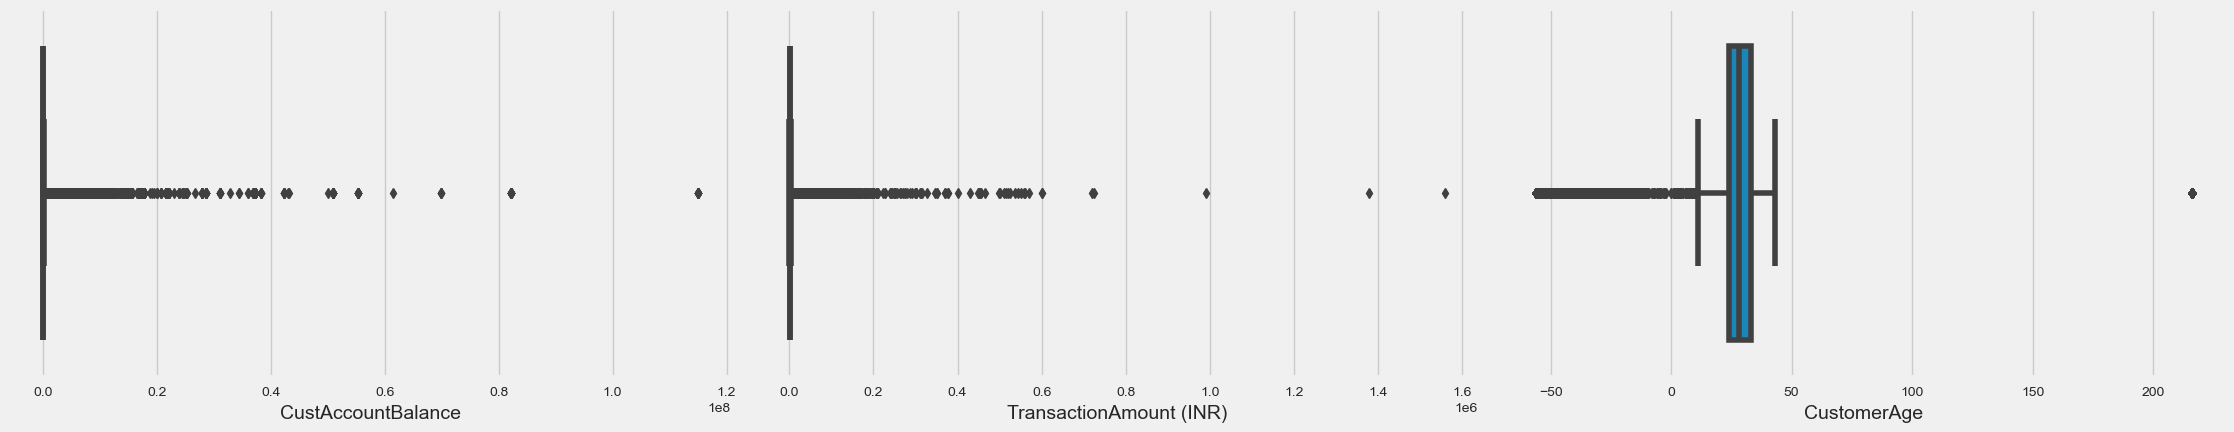

In [17]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index,column in enumerate(num_col):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=num_col,x=column)
    
plt.tight_layout(pad = 1.0)

- There are no outliers present as such
- The age is negative because anyone can open a Life Saver youth savings account on behalf of a child or grandchild .

###### To perform RFM 
- Recency  (the freshness of customer activity)  e.g. time since last activity
- Frequency (the frequency of customer transactions) e.g. the total number of recorded transactions
- Monetory (the willingness to spend) e.g. total transaction value

Recency: number of days since the last purchase or order so I will create a new column of TransactionDate to subtract the last transaction from the first transaction

In [18]:
#df['TransactionDate1'] ==> I will keep it to do visaulization
df['TransactionDate1']=df['TransactionDate'] # ==> to calculate the minimum (first transaction)
df['TransactionDate2']=df['TransactionDate'] # ==> to calculate the maximum (last transaction)

#### Creating MRF table strategy

In [20]:
MRF_df = df.groupby("CustomerID").agg({
    "TransactionID" : "count",
    "CustGender" : "first",
    "CustLocation" : "first",
    "CustAccountBalance" : "mean",
    "TransactionAmount (INR)" : "mean",
    "CustomerAge" : "median",
    "TransactionDate2" : "max",
    "TransactionDate1" : "min",
    "TransactionDate" : "median"
    
})
MRF_df = MRF_df.reset_index()
MRF_df.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18


In [21]:
MRF_df.shape

(879357, 10)

In [22]:
MRF_df.drop(columns=["CustomerID"],inplace=True)

In [23]:
MRF_df.rename(columns={"TransactionID":"Frequency"},inplace=True)

In [24]:
MRF_df['Recency']=MRF_df['TransactionDate2']-MRF_df['TransactionDate1']

In [25]:
MRF_df['Recency']=MRF_df['Recency'].astype(str)

In [26]:
MRF_df

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17,18 days
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14,0 days
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08,182 days
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15,0 days
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18,0 days
...,...,...,...,...,...,...,...,...,...,...
879352,1,M,BHIWANDI,133067.230,691.0,26.0,2016-07-08,2016-07-08,2016-07-08,0 days
879353,1,M,BANGALORE,96063.460,222.0,20.0,2016-09-15,2016-09-15,2016-09-15,0 days
879354,1,M,GUNTUR,5559.750,126.0,23.0,2016-08-18,2016-08-18,2016-08-18,0 days
879355,1,M,CHENNAI,35295.920,50.0,21.0,2016-08-28,2016-08-28,2016-08-28,0 days


In [27]:
# extract the day
x='18 day'
re.search('\d+',x).group()

'18'

In [28]:
MRF_df['Recency']=MRF_df['Recency'].apply(lambda x :re.search('\d+',x).group())
MRF_df['Recency']=MRF_df['Recency'].astype(int)

In [29]:
MRF_df

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17,18
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14,0
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08,182
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15,0
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18,0
...,...,...,...,...,...,...,...,...,...,...
879352,1,M,BHIWANDI,133067.230,691.0,26.0,2016-07-08,2016-07-08,2016-07-08,0
879353,1,M,BANGALORE,96063.460,222.0,20.0,2016-09-15,2016-09-15,2016-09-15,0
879354,1,M,GUNTUR,5559.750,126.0,23.0,2016-08-18,2016-08-18,2016-08-18,0
879355,1,M,CHENNAI,35295.920,50.0,21.0,2016-08-28,2016-08-28,2016-08-28,0


In [30]:
# 0 recency means customer has transaction one time by logic so I will convert 0 to 1

In [31]:
def rep_0(i):
    if i==0:
        return 1
    else:
        return i
MRF_df['Recency']=MRF_df['Recency'].apply(rep_0)

In [32]:
MRF_df

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17,18
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14,1
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08,182
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15,1
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18,1
...,...,...,...,...,...,...,...,...,...,...
879352,1,M,BHIWANDI,133067.230,691.0,26.0,2016-07-08,2016-07-08,2016-07-08,1
879353,1,M,BANGALORE,96063.460,222.0,20.0,2016-09-15,2016-09-15,2016-09-15,1
879354,1,M,GUNTUR,5559.750,126.0,23.0,2016-08-18,2016-08-18,2016-08-18,1
879355,1,M,CHENNAI,35295.920,50.0,21.0,2016-08-28,2016-08-28,2016-08-28,1


In [33]:
MRF_df.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)

##### to calculate outliers for each features

In [34]:
lower_list = []
upper_list = []
num_list = []
perc_list = []
cols = ['Frequency', 'CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge', 'Recency']
for i in cols:
    Q1 = MRF_df[i].quantile(0.25)
    Q3 = MRF_df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    #calculate number of outliers
    num = MRF_df[(MRF_df[i]< lower) | MRF_df[i] > upper].shape[0]
    
    #calculate the % of outliers
    perc = (num/MRF_df.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))

dic = {"lower" : lower_list, "upper" : upper_list, "outliers" : num_list, "Perc%" : perc_list}
outliers_df = pd.DataFrame(dic,index = ['Frequency', 'CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge', 'Recency'])
outliers_df

,lower,upper,outliers,Perc%
Frequency,1.000,1.000,0,0.0
CustAccountBalance,-78334.780,145468.020,0,0.0
TransactionAmount (INR),-1384.325,2816.195,0,0.0
CustomerAge,10.500,46.500,0,0.0
Recency,1.000,1.000,0,0.0


In [35]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,1


##### Exploratory Data Analysis

In [36]:
MRF_df.describe()

,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
count,879357.000000,8.793570e+05,8.793570e+05,879357.000000,879357.000000
mean,1.184517,1.147151e+05,1.566759e+03,32.870961,15.876154
std,0.448954,8.010842e+05,6.433167e+03,46.609586,46.653921
min,1.000000,0.000000e+00,0.000000e+00,-56.000000,1.000000
25%,1.000000,5.591270e+03,1.908700e+02,24.000000,1.000000
50%,1.000000,1.866578e+04,5.000000e+02,28.000000,1.000000
75%,1.000000,6.154197e+04,1.241000e+03,33.000000,1.000000
max,6.000000,1.150355e+08,1.560035e+06,216.000000,336.000000


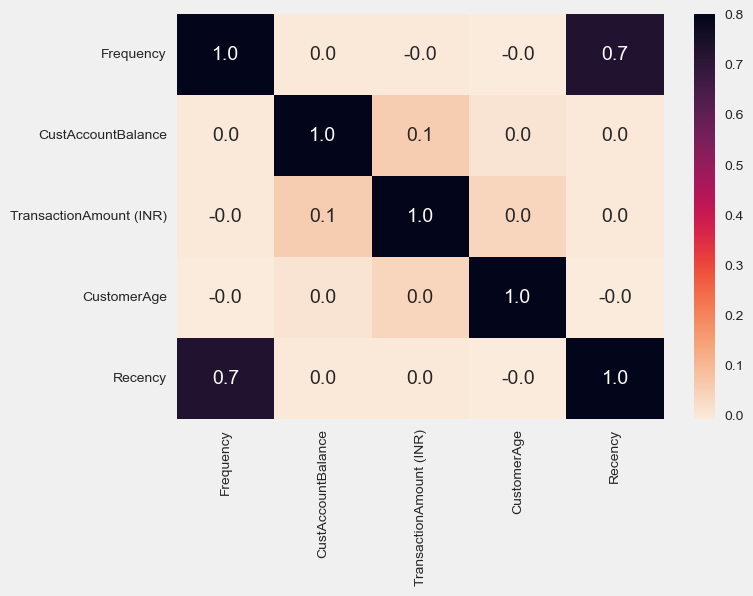

In [37]:
# correlation between features
plt.figure(figsize=(7,5))
correlation=MRF_df.corr()
sns.heatmap(correlation,vmin=None,
    vmax=0.8,
    cmap='rocket_r',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True);

################# to run this code again afterwards as it is taking a lot of time to complete #####################

In [46]:
# plt.style.use("fivethirtyeight")
# sns.pairplot(MRF_df,hue='Frequency');

In [47]:
# plt.style.use("fivethirtyeight")
# chart=sns.countplot(x='Frequency',data=MRF_df,palette='rocket', order = MRF_df['Frequency'].value_counts().index)
# plt.title("Frequency",
#           fontsize='20',
#           backgroundcolor='AliceBlue',
#           color='magenta');

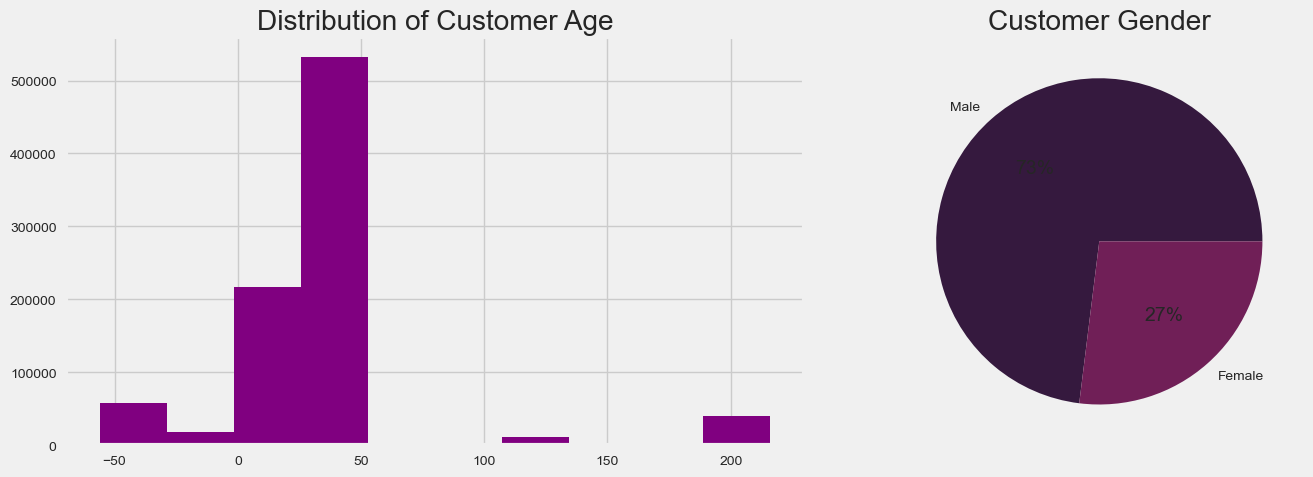

In [40]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=MRF_df['CustomerAge'],color='purple')
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(MRF_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1].set_title("Customer Gender")
plt.tight_layout();

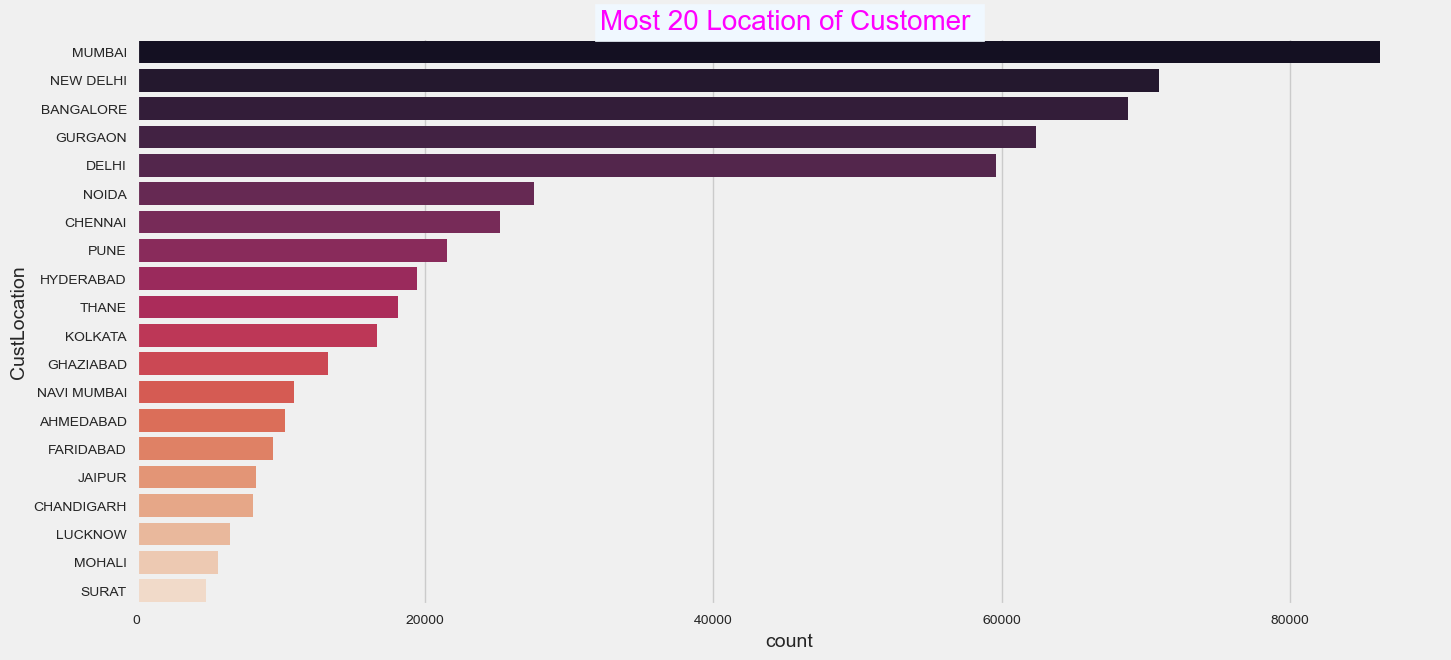

In [41]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=MRF_df,palette='rocket', order = MRF_df['CustLocation'].value_counts()[:20].index)
plt.title("Most 20 Location of Customer ",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

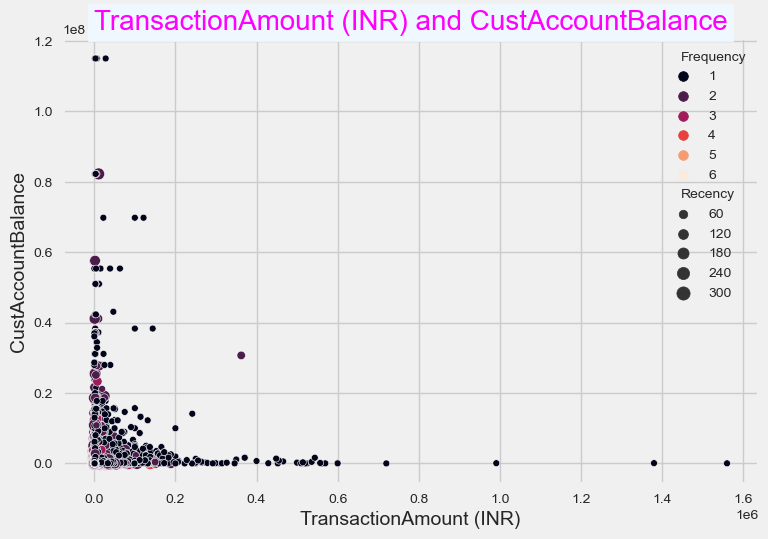

In [42]:
plt.style.use("fivethirtyeight")
sns.scatterplot(x='TransactionAmount (INR)',y='CustAccountBalance',data=MRF_df,palette='rocket',hue='Frequency',size='Recency' )
plt.title("TransactionAmount (INR) and CustAccountBalance",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

In [43]:
# difference between maximum and minimum date
MRF_df['TransactionDate'].max()-MRF_df['TransactionDate'].min()

Timedelta('336 days 00:00:00')

In [44]:
MRF_df=MRF_df.sort_values(by='TransactionDate')
groupbby_month=MRF_df.groupby([pd.Grouper(key='TransactionDate',freq='M')]).mean()
print(groupbby_month.shape)
groupbby_month

(12, 5)


,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
TransactionDate,,,,,
2016-01-31,1.025196,107508.805797,1448.714678,33.117387,1.918747
2016-02-29,1.064317,105680.497569,1502.272034,33.397089,5.091711
2016-03-31,1.091612,111479.999592,1643.042085,32.519724,8.617264
2016-04-30,1.172430,114318.492265,1691.246723,31.694946,25.188155
2016-05-31,1.355424,109561.572298,1592.128640,32.489199,62.542281
2016-06-30,1.359702,109571.765181,1658.123285,32.300006,53.389229
2016-07-31,1.354797,106349.124901,1573.295768,31.827322,37.011021
2016-08-31,1.158752,120503.189601,1569.334883,33.157626,7.485432
2016-09-30,1.211712,117934.764734,1530.263571,33.446020,10.531790


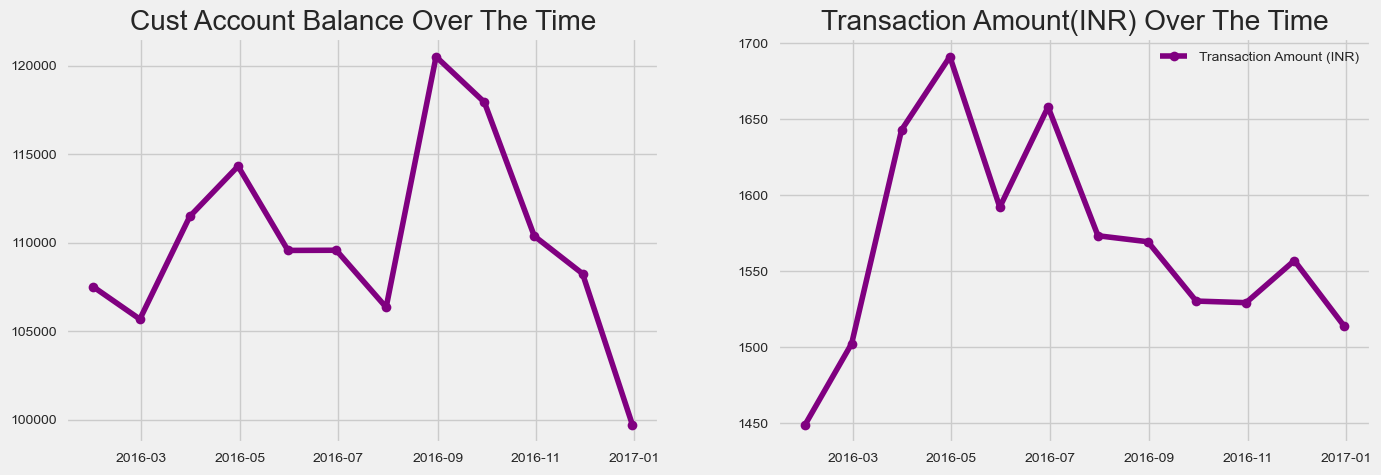

In [45]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
ax[0].plot(groupbby_month.index,groupbby_month['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance')
ax[0].set_title('Cust Account Balance Over The Time')
ax[1].plot(groupbby_month.index,groupbby_month['TransactionAmount (INR)'],color='purple',marker='o',label='Transaction Amount (INR)')
ax[1].set_title("Transaction Amount(INR) Over The Time")
plt.legend();

##### Feature Engineering

In [48]:
MRF_df=MRF_df.reset_index(drop=True)

In [49]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,1,F,AHMEDABAD,703891.99,2000.00,29.0,2016-01-08,1
1,1,M,MUMBAI,156310.08,1347.90,-51.0,2016-01-08,1
2,1,M,OPP SAI BABA TEMPLE HYDERABAD,95792.79,9900.00,216.0,2016-01-08,1
3,1,M,DELHI,1753.41,154.05,27.0,2016-01-08,1
4,1,M,DELHI,39579.53,194.00,30.0,2016-01-08,1


In [50]:
MRF_df.drop(columns=['CustLocation','TransactionDate'],inplace=True)

In [51]:
MRF_df['CustGender']=MRF_df['CustGender'].map({'M':1,'F':0})

In [52]:
# data scaling
df_scaled=StandardScaler().fit_transform(MRF_df)
df_scaled=pd.DataFrame(df_scaled,columns=MRF_df.columns)
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,-0.410992,-1.645853,0.735475,0.067345,-0.083051,-0.318862
1,-0.410992,0.607588,0.051923,-0.034020,-1.799437,-0.318862
2,-0.410992,0.607588,-0.023621,1.295357,3.929002,-0.318862
3,-0.410992,0.607588,-0.141011,-0.219598,-0.125960,-0.318862
4,-0.410992,0.607588,-0.093792,-0.213388,-0.061596,-0.318862


In [53]:
df_scaled=df_scaled.sample(n=100000,random_state=42).reset_index(drop=True)
df_scaled.head()# to use only 100000 sample data

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,1.816407,-1.645853,-0.112481,-0.197377,-0.115233,0.195565
1,1.816407,-1.645853,-0.096483,-0.234310,0.024223,0.538516
2,-0.410992,0.607588,-0.141308,-0.212455,-0.083051,-0.318862
3,1.816407,-1.645853,-0.045140,-0.227222,1.901521,0.195565
4,-0.410992,0.607588,-0.126809,-0.159915,-0.147415,-0.318862


#### Modelling

In [ ]:
# Kmeans algorithm settings
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}

inertias = []
silhouette_coefficients = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

In [ ]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(2,11), inertias, curve='convex', direction="decreasing")
ax[0].plot(range(2,11), inertias,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

ax[1].plot(range(2,11), silhouette_coefficients,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

In [ ]:
plt.figure(figsize=(30,10))
z = sch.linkage(df_scaled.iloc[:500,:], 'ward')
sch.dendrogram(z);

In [ ]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)    
kmeans.fit(df_scaled)
df_scaled['Label']=kmeans.labels_
df_scaled.head()

In [ ]:
sns.pairplot(df_scaled,hue='Label');

In [ ]:
attributes = df_scaled.columns[:6]
colors=['purple','yellow','red','blue','magenta','orange']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6']

fig = go.Figure()
for index in range(0,6):
    fig.add_trace(go.Scatterpolar(r=np.mean(df_scaled.loc[df_scaled.Label == index, attributes]),
                                  theta=attributes,
                                  fill='toself',
                                  fillcolor=colors[index],
                                  opacity=0.4,
                                  name=cluster[index]))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()

#### PCA

In [ ]:
# here we want to check how many component we need to explain 90%  of the variance
plt.style.use("fivethirtyeight")
pca = PCA().fit(df_scaled.iloc[:,:-1])
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='purple',marker='o')  #EX: cusum([4,2,3,1,6]) ==>[4,6,9,10,16]
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# x tickes
plt.xticks(np.arange(0, 10, 1))
plt.show();

In [ ]:
pca = PCA(n_components=4)
pca_data = pca.fit_transform(df_scaled.iloc[:,:-1])

inertia = []
silhouette = []


for k in range(2,11):
    km = KMeans(init='k-means++', n_clusters=k, random_state=42)
    km.fit(pca_data)
    inertia.append(km.inertia_)
    P_score=silhouette_score(pca_data, km.labels_)
    silhouette.append(P_score)

In [ ]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
Pkl = KneeLocator(range(2,11), inertia, curve='convex', direction="decreasing")
# draw Elbow
ax[0].plot(range(2,11), inertia,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=Pkl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)
# draw silhouette
ax[1].plot(range(2,11), silhouette,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

In [ ]:
plt.figure(figsize=(30,10))
z = sch.linkage(pca_data[:350,:], 'ward')
sch.dendrogram(z);

In [ ]:
PCA_kmeans = KMeans(n_clusters=5 , **kmeans_set)    
PCA_kmeans.fit(pca_data)
# create a dataframe for the pca data
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['label'] = PCA_kmeans.labels_
pca_df.head()

In [ ]:
sns.pairplot(pca_df,hue='label');

In [ ]:
attributes = pca_df.columns[:4]
colors=['purple','yellow','red','blue']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4']

fig = go.Figure()
for index in range(0,4):
    fig.add_trace(go.Scatterpolar(r=np.mean(pca_df.loc[pca_df.label == index, attributes]),
                                  theta=attributes,
                                  fill='toself',
                                  fillcolor=colors[index],
                                  opacity=0.4,
                                  name=cluster[index]))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()